In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT
from ATARI.syndat.control import Syndat_Control


In [2]:
%matplotlib widget

## AutoFit User Example

This notebook gives an examle how the ATARI.AutoFit module can be used to automatically fit data with no need for a prior.

In [3]:

# plotting data & fits
# default fig size to output
fig_size = (8,6)

# if we will save images - where to save
savefolder = 'anim_create/'
if not os.path.exists(savefolder):
    # If it doesn't exist, create it
    os.makedirs(savefolder)

def plot_datafits(datasets, experiments, 
    fits=[], fits_chi2=[],
    priors=[], priors_chi2=[],
    true=[], true_chi2=[],
    true_pars = pd.DataFrame(), 
    prior_pars = pd.DataFrame(),
    fit_pars = pd.DataFrame(),
    title: str = '',
    show_spingroups: bool = True,
    fig_size : tuple = (8,6)
    ):

    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=fig_size, sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color='black', alpha=0.5, linewidth=1.0, markersize=4, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            if (len(fits_chi2) != 0):
                fit_label = f'fit {exp.title} ({fits_chi2[i]})'
            else:
                fit_label = f'fit {exp.title}'
            axes[iax].plot(fits[i].E, fits[i][model_key], color='red', zorder=1, lw=1.5, label=fit_label) # colors[i]
        
        if len(priors) != 0:
            if (len(priors_chi2) != 0):
                prior_label = f'prior {exp.title} ({priors_chi2[i]})'
            else:
                prior_label = f'prior {exp.title}'

            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color='orange', zorder=0, lw=1.5, label=prior_label)
        
        if len(true) != 0:
            if (len(true_chi2) != 0):
                true_label = f'true {exp.title} ({true_chi2[i]})'
            else:
                true_label = f'true {exp.title}'
            axes[iax].plot(true[i].E, true[i]['true'], '-', color='green', zorder=1, alpha=0.5, lw=1.5, label=true_label)


    # Set the y-axis limits with additional space for text and capture ymax before changing
    
    y_top_padding = 0.1 
    x_offset = 0.05

    ymax_values = [ax.get_ylim()[1] for ax in axes]  # Store original ymax values for each axis
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax + y_top_padding)

    font_size = 8
    y_text_shift = 0.01  # Adjust as needed, related to font size
    y_text_positions = [ymax_values[0], ymax_values[1]]

    # show vertical lines for energies
    
    # fits
    for index, res in fit_pars.iterrows():
        res_E = res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)
        axes[1].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(int(res.J_ID),0)
            
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = res_E + x_offset
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                #ax.text(x_text_position, y_text_position, str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=8)

                ax.text(res_E, y_text_positions[i], str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=font_size)
                y_text_positions[i] -= y_text_shift


    # the same for theoretical positions
    for index, true_res in true_pars.iterrows():

        true_res_energy = true_res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)
        axes[1].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(true_res.J_ID,0)
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = true_res_energy
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                ax.text(x_text_position , y_text_position, str(sp_gr_txt), color='g', verticalalignment='bottom', fontsize=8)

    
    for index, res in prior_pars.iterrows():
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)
        axes[1].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    # set title
    fig.suptitle(title, fontsize=14)
    
    # additional info if present
    add_title = ''
    if (true_pars.shape[0]>0):
        add_title+=''+r'$N_{true}$ = '+str(true_pars.shape[0])
        
    if (len(true_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(true_chi2),3))

    if (prior_pars.shape[0]>0):
        add_title+=', '+r'$N_{prior}$ = '+str(prior_pars.shape[0])
    if (len(priors_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(priors_chi2),3))

    if (fit_pars.shape[0]>0):
        add_title+=', '+r'$N_{fit}$ = '+str(fit_pars.shape[0])
    if (len(fits_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(fits_chi2),3))
    
    # end additional info if present
    axes[0].set_title(add_title, fontsize=10)
    

    # ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        # ax.set_ylim([-0.1,1.1])
        ax.legend(fontsize='small', loc='lower right')

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

## First, generate data with Syndat to play with

In [41]:
erange_all = [200, 225]


### Reaction Model
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        total_energy_range = erange_all,
                        ac = 8.127,
                        M = 180.94803,
                        I = 3.5,
                        l_max = 1
)

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=8.79,
                       gn2_avg=46.5,
                       gn2_dof=1,
                       gg2_avg=64.0/2,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=4.99,
                       gn2_avg=35.5,
                       gn2_dof=1,
                       gg2_avg=64.0/2,
                       gg2_dof=1000)

### Experimental Models
cap1mm_exp_gen = Experimental_Model(title = "cap1",
                                reaction ="capture", 
                                energy_range = erange_all,
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )

trans1mm_exp_gen = Experimental_Model(title = "trans1",
                               reaction = "transmission", 
                               energy_range = erange_all,
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),
                               channel_widths={
                                    "maxE": [216.16, 613.02], 
                                    "chw": [204.7, 102.4],
                                    "dchw": [1.6, 1.6]
                                }
                               )

sammy_rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })

template_creator.make_input_template('template_T.inp', Ta_pair, trans1mm_exp_gen, sammy_rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, cap1mm_exp_gen, sammy_rto)

cap1mm_exp_gen.template = os.path.realpath('template_Y.inp')
trans1mm_exp_gen.template = os.path.realpath('template_T.inp')

### Measurement Models
cap1mm_meas_gen = Capture_Yield_RPI()
cap1mm_meas_red = Capture_Yield_RPI()

trans1mm_meas_gen = Transmission_RPI()
trans1mm_meas_red = Transmission_RPI()


### Syndat Models
options_cap1mm = syndatOPT(calculate_covariance=False)

syndat_cap1mm = Syndat_Model(cap1mm_exp_gen,
                            cap1mm_meas_gen,
                            cap1mm_meas_red,
                            options = options_cap1mm,
                            title='cap1mm')

options_trans1mm = syndatOPT(calculate_covariance = True)
syndat_trans1mm = Syndat_Model(trans1mm_exp_gen,
                            trans1mm_meas_gen,
                            trans1mm_meas_red,
                            options = options_trans1mm,
                            title='trans1mm')

In [42]:
### Control module for sampling from multiple syndat models

options_control = syndatOPT(sampleRES=True)
syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models= [syndat_trans1mm, syndat_cap1mm],
                        model_correlations=None,
                        options=options_control
                        )

syndat.sample(sammy_rto, num_samples=1)

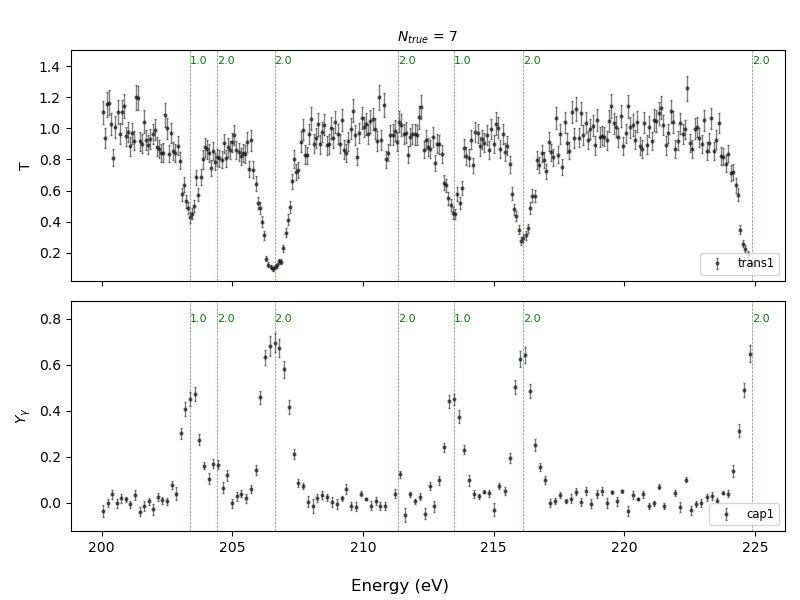

In [43]:
### unpack sample and plot

sample1 = syndat.get_sample(0)
true_ladder = copy(sample1['trans1mm'].par_true)
true_ladder['varyE'] = np.ones(len(true_ladder))
true_ladder['varyGg'] = np.ones(len(true_ladder))
true_ladder['varyGn'] = np.ones(len(true_ladder))

datasets = [sample1['cap1mm'].pw_reduced, sample1['trans1mm'].pw_reduced]#, transdat3, transdat6]
experiments= [cap1mm_exp_gen, trans1mm_exp_gen]#, exptrans3, exptrans6]
covariance_data = [sample1['cap1mm'].covariance_data, sample1['trans1mm'].covariance_data]

# fig = plot(datasets, experiments, fits=[], priors=[], true=datasets)
# fig.tight_layout()


fig = plot_datafits(datasets, experiments, 
    true_pars = true_ladder, 
    prior_pars = pd.DataFrame(),
)

fig.tight_layout()



In [60]:
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


options = InitialFBOPT(Gn_threshold=1e-1,
                       iterations=3,
                       max_steps = 20,
                       LevMarV0=0.1,
                       fit_all_spin_groups=False,
                       spin_group_keys = ['3.0'],
                       step_threshold=0.001,
                       starting_Gn1_multiplier = 50)
autofit_initial = InitialFB(options)

In [61]:
outs = autofit_initial.fit(Ta_pair,
                               [200,225],
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)

	FIT 1
Initial solve from 31 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum', 'sum/ndat']
0    0.1  : [6566.34, 40106.4, 46672.74, 110.5989]
1    0.15 : [5730.14, 31121.7, 36851.84, 87.3266]
2    0.225: [3096.98, 8101.36, 11198.34, 26.5364]
3    0.338: [1205.66, 1409.65, 2615.31, 6.1974]
4    0.506: [1217.86, 1161.14, 2379.0, 5.6374]
5    0.759: [1198.96, 1156.42, 2355.38, 5.5815]
6    1.139: [1189.83, 1155.48, 2345.31, 5.5576]
7    1.709: [1185.03, 1154.99, 2340.02, 5.5451]
8    2.0  : [1182.38, 1154.77, 2337.15, 5.5383]
9    2.0  : [1181.33, 1154.71, 2336.04, 5.5356]
10    2.0  : [1180.89, 1154.66, 2335.55, 5.5345]
11    2.0  : [1180.64, 1154.66, 2335.3, 5.5339]
Chi2 improvement below threshold

----------------------------------------
Eliminated 41.94% of resonance features based on neuton width
Resolving with 18 resonance features
----------------------------------------

Stepping until convergence
chi2 values
step fudge: ['cap1', 'tr

In [67]:
final_fb_output  = outs.sammy_outs_fit_1[0]


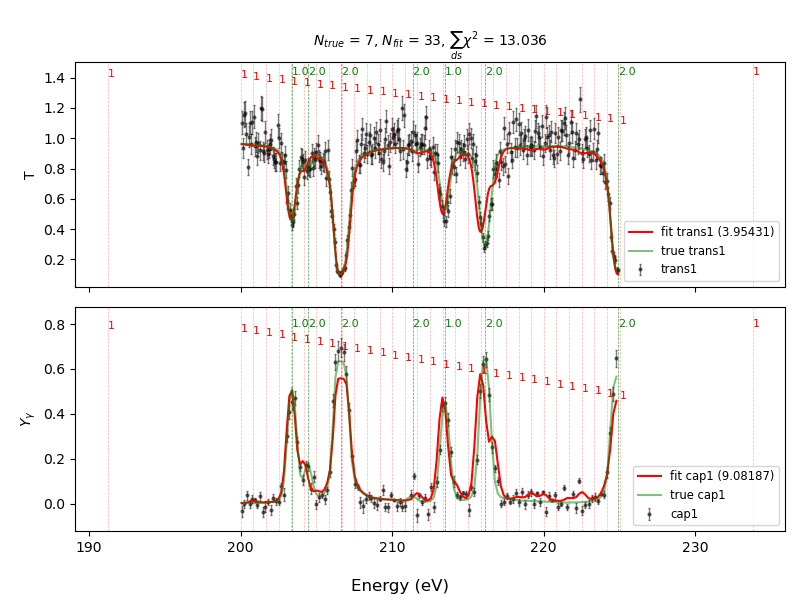

In [68]:
fig = plot_datafits(datasets, experiments, 
    fits=final_fb_output.pw_post, 
    fits_chi2=final_fb_output.chi2n_post,
    priors=[], priors_chi2=[],
    true=datasets, true_chi2=[],
    true_pars = true_ladder, 
    prior_pars = pd.DataFrame(),
    fit_pars = final_fb_output.par_post,
    # title: str = '',
    show_spingroups = True,
    fig_size = (8,6)
)

In [71]:
len(start_ladder)

20

In [70]:
import importlib
from ATARI.AutoFit import chi2_eliminator_v2

importlib.reload(chi2_eliminator_v2)

start_ladder =  outs.final_resonace_ladder #true_ladder#
assert isinstance(start_ladder, pd.DataFrame)

# side resonances - keep empty
side_resonances_df = pd.DataFrame()

# defining rto & inputs

elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 5,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.05
    )

# defining the elim_opts
elim_opts = chi2_eliminator_v2.elim_OPTs(chi2_allowed = 50,
                                      fixed_resonances_df = side_resonances_df,
                                      deep_fit_max_iter = 5,
                                      deep_fit_step_thr = 0.1,
                                      start_fudge_for_deep_stage = 0.1
                                      )

In [59]:
elimi = chi2_eliminator_v2.eliminator_by_chi2(rto=sammy_rto_fit,
                                            sammyINPyw = elim_sammyINPyw , 
                                            options = elim_opts
                            )

In [72]:
hist = elimi.eliminate(ladder_df=start_ladder)

****************************************
Elimination cycle printout enabled
****************************************

	Chi2 thresold applied for model selection: 50
	Stopping options:
	stop_at_chi2_thr: True
	"Greedy" mode: False
	Use spin shuffling: False
	Starting deep fitting and/or reshuffling from N = 10 res. (excl. fixed side res.)

Input ladder:
             E         Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0   233.790000  54.892472   2.903548    0.0     1.0      1.0   1.0
1   191.210000  50.295727   3.000584    0.0     1.0      1.0   1.0
2   200.715135  62.733284   0.135069    1.0     1.0      1.0   1.0
3   203.395263  54.908117  13.727391    1.0     1.0      1.0   1.0
4   204.333386  57.087322   2.200450    1.0     1.0      1.0   1.0
5   204.636802  60.004714   0.443528    1.0     1.0      1.0   1.0
6   205.960334  56.723299   0.570367    1.0     1.0      1.0   1.0
7   206.620306  80.087738  76.167636    1.0     1.0      1.0   1.0
8   211.410381  44.611032   1.076887    1.

In [64]:
print(f'Eliminated from {hist.ladder_IN.shape[0]} res -> {hist.ladder_OUT.shape[0]}')
minkey = min(hist.elimination_history.keys())

sammyOUT_elim = hist.elimination_history[minkey]['selected_ladder_chars']

# fig = plot(datasets, experiments, fits=sammyOUT_elim.pw_post, priors=[], true=datasets)
# fig.tight_layout()

fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_elim.pw_post, 
    fits_chi2=sammyOUT_elim.chi2n_post,
    priors=[], priors_chi2=[],
    true=datasets, true_chi2=[],
    true_pars = true_ladder, 
    prior_pars = pd.DataFrame(),
    fit_pars = sammyOUT_elim.par_post,
    # title: str = '',
    show_spingroups = True,
    fig_size = (8,6)
)

fig.tight_layout()

AttributeError: 'function' object has no attribute 'ladder_IN'

In [16]:
# sammyOUT_elim3 = hist2.elimination_history[14]['selected_ladder_chars']
# # outfit
# fig = plot(datasets, experiments, fits=sammyOUT_elim3.pw, priors=[], true=datasets)
# fig.tight_layout()

In [17]:
len(sammyOUT_elim.par_post)

5

In [16]:
from itertools import permutations, product

all_J_ID = list(product([1.0,2.0], repeat=3))
all_J_ID

[(1.0, 1.0, 1.0),
 (1.0, 1.0, 2.0),
 (1.0, 2.0, 1.0),
 (1.0, 2.0, 2.0),
 (2.0, 1.0, 1.0),
 (2.0, 1.0, 2.0),
 (2.0, 2.0, 1.0),
 (2.0, 2.0, 2.0)]

In [18]:
from ATARI.AutoFit.spin_group_selection import SpinSelectOPT, SpinSelect


spinselectOPT = SpinSelectOPT(step_threshold=0.01,
                              max_steps=10)
spinselector = SpinSelect(spinselectOPT)

sammyOUT_spin = spinselector.get_best_chi2([1.0,2.0],
                                            sammyOUT_elim.par_post,
                                            Ta_pair,
                                            datasets,
                                            experiments,
                                            covariance_data,
                                            sammy_rto_fit)

Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.05 : [3.2245, 2.3286, 5.5531]
Repeat step 1, 	fudge: ['cap1', 'trans1', 'sum']
		0.01 : [3.2245, 2.3286, 5.5531]
1    0.01 : [3.2245, 2.3286, 5.5531]
Chi2 improvement below threshold
Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.05 : [3.2245, 2.3286, 5.5531]
Repeat step 1, 	fudge: ['cap1', 'trans1', 'sum']
		0.01 : [3.2245, 2.3286, 5.5531]
1    0.01 : [3.2245, 2.3286, 5.5531]
Chi2 improvement below threshold
Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.05 : [3.6076, 2.6564, 6.2641]
1    0.1  : [3.2985, 2.3354, 5.6339]
2    0.2  : [3.2687, 2.33, 5.5987]
3    0.4  : [3.2648, 2.3299, 5.5947]
Chi2 improvement below threshold
Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.05 : [3.5811, 2.5188, 6.0999]
1    0.1  : [3.2767, 2.3297, 5.6064]
2    0.2  : [3.2344, 2.3232, 5.5577]
3    0.4  : [3.2296, 2

In [ ]:
print(sammyOUT_elim.chi2n_post, np.sum(sammyOUT_elim.chi2n_post))
print(sammyOUT_spin.chi2n_post, np.sum(sammyOUT_elim.chi2n_post))
print(sammyOUT_elim.par_post)
print(sammyOUT_spin.par_post)

[3.66698, 2.63495] 6.3019300000000005
[3.45016, 2.25848] 6.3019300000000005
            E         Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0  202.622034  86.006488   19.507632    1.0     1.0      1.0   1.0
1  204.404854  75.343746  122.956542    1.0     1.0      1.0   1.0
2  209.335650  72.819822  314.673510    1.0     1.0      1.0   1.0
3  215.342296  84.895165   30.644780    1.0     1.0      1.0   1.0
4  219.670895  59.838597   26.180259    1.0     1.0      1.0   1.0
            E         Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0  202.621444  85.903758   20.075128    1.0     1.0      1.0   1.0
1  204.366783  73.367735  117.908294    1.0     1.0      1.0   1.0
2  209.365684  68.835729  268.318424    1.0     1.0      1.0   2.0
3  215.351087  85.117471   30.858574    1.0     1.0      1.0   1.0
4  219.675440  59.969220   26.389878    1.0     1.0      1.0   1.0


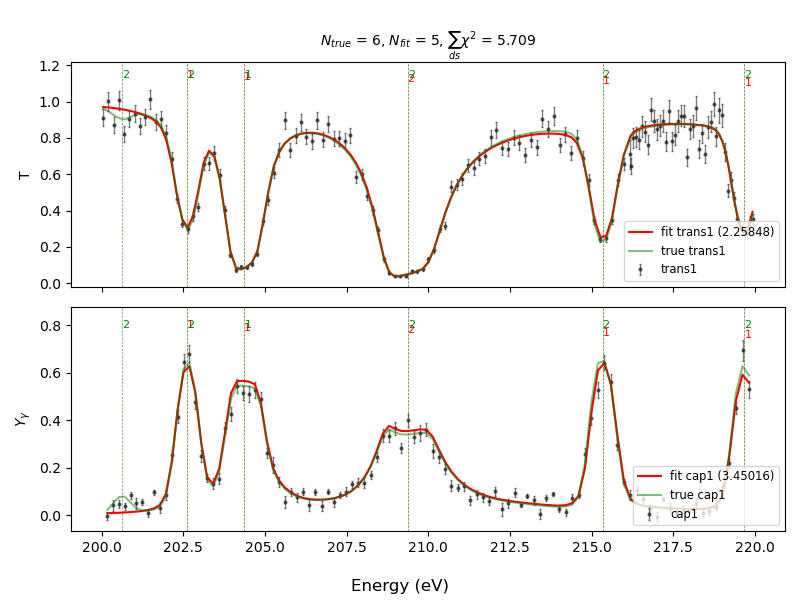

In [ ]:
fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_spin.pw_post, 
    fits_chi2=sammyOUT_spin.chi2n_post,
    priors=[], priors_chi2=[],
    true=datasets, true_chi2=[],
    true_pars = true_ladder, 
    # prior_pars = sammyOUT_elim.par_post,
    fit_pars = sammyOUT_spin.par_post,
    # title: str = '',
    show_spingroups = True,
    fig_size = (8,6)
)

fig.tight_layout()